In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [0]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

In [0]:
import sys
import os
import pandas as pd
import numpy as np
import gc

mod = sys.modules[__name__]

path = 'drive/My Drive/bigcontest2019/data/'

# Data Merge


In [0]:
# function define

def week_transform(row):
    if row>0 and row<8:
        row = 1
    elif row>7 and row<15:
        row = 2
    elif row>14 and row<22:
        row = 3
    else:
        row = 4
    return row

def merge_by_acc_id(df_list):
    '''
    df_list
    '''
    df = eval(df_list[0])

    for arg in df_list[1:]:
        df_arg = eval(arg)
        df = pd.merge(df, df_arg,left_index=True, right_index=True, how='left')

    return df

def pivoting_df(df):
    ind = list(df.columns)[0]
    col = list(df.columns)[1]
    
    names = list(df.columns)[2:]

    for name in names:
        tmp = df.pivot(index = ind, columns= col,values=name).fillna(0)
        tmp.columns = [name+'_day'+str(x) for x in tmp.columns]

        setattr(mod, '{}'.format(name), tmp)

    final_df = merge_by_acc_id(names)
    
    return final_df

def merge_final_df(df,*args):
    '''
    df : 기준이 되는 데이터 프레임 (acc_id가 전부 있는 쪽으로!!)
    *args : 가변인자 (데이터 프레임을 원하는 만큼 집어넣으면 된다.)
    '''    
    df['acc_id'] = list(df.index)
    df.reset_index(drop=True,inplace=True)
    
    for arg in args:
        arg['acc_id'] = list(arg.index)
        arg.reset_index(drop=True,inplace=True)
        df = pd.merge(df, arg, how='left',on= 'acc_id').fillna(0)
    
    return df

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [0]:
train_payment_group = train_payment.groupby(['acc_id','day']).agg({'amount_spent':'sum'}).reset_index(drop=False)
train_payment_group.columns = ['payment_'+i for i in train_payment_group.columns]

train_payment_char = pivoting_df(train_payment_group)

In [0]:
train_payment_char

,payment_amount_spent_day1,payment_amount_spent_day2,payment_amount_spent_day3,payment_amount_spent_day4,payment_amount_spent_day5,payment_amount_spent_day6,payment_amount_spent_day7,payment_amount_spent_day8,payment_amount_spent_day9,payment_amount_spent_day10,payment_amount_spent_day11,payment_amount_spent_day12,payment_amount_spent_day13,payment_amount_spent_day14,payment_amount_spent_day15,payment_amount_spent_day16,payment_amount_spent_day17,payment_amount_spent_day18,payment_amount_spent_day19,payment_amount_spent_day20,payment_amount_spent_day21,payment_amount_spent_day22,payment_amount_spent_day23,payment_amount_spent_day24,payment_amount_spent_day25,payment_amount_spent_day26,payment_amount_spent_day27,payment_amount_spent_day28
payment_acc_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,1.056123,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.348521,0.000000,0.000000
20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035204,0.000000,0.035204,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.826123,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.346940,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.348521,0.000000,0.000000
38,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.442398,0.000000,0.000000,0.000000,0.000000,0.586735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.280616,0.000000,0.000000,0.000000,0.000000,0.000000
41,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035204
43,3.696431,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
53,0.000000,0.477602,0.000000,0.023469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
62,0.000000,0.528062,0.000000,0.000000,0.000000,1.056123,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.335206,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.371990,0.000000,0.000000
63,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058674,0.000000,0.528062,1.056123,0.000000,0.000000,0.000000,0.000000,0.000000,0.117347


## train


In [0]:
path = '/drive/My Drive/bigcontest2019/'

In [0]:
# train

train_activity = pd.read_csv(path + 'train/train_activity.csv').sort_values(['acc_id','day'])
train_payment = pd.read_csv(path + 'train/train_payment.csv').sort_values(['acc_id','day'])
# train_trade = pd.read_csv(path + 'train/train_trade.csv')
# train_pledge = pd.read_csv(path + 'train/train_pledge.csv').sort_values(['acc_id','day'])
# train_combat = pd.read_csv(path + 'train/train_combat.csv').sort_values(['acc_id','day'])


# train_activity['day'] = train_activity['day'].apply(week_transform)
# train_payment['day'] = train_payment['day'].apply(week_transform)
# train_trade['day'] = train_trade['day'].apply(week_transform)
# train_pledge['day'] = train_pledge['day'].apply(week_transform)
# train_combat['day'] = train_combat['day'].apply(week_transform)

# # activity
# train_activity['game_money_change'] = np.abs(train_activity['game_money_change'])
# train_activity_group = train_activity.groupby(['acc_id','day']).agg({
#                                                              'server':'nunique',
#                                                              'char_id':'nunique',
#                                                              'playtime':['sum','mean'], 
#                                                              'npc_kill':['sum','mean'], 
#                                                              'solo_exp':'sum',
#                                                              'party_exp':'sum', 
#                                                              'quest_exp':'sum',
#                                                              'rich_monster':'sum', 
#                                                              'death':'sum', 
#                                                              'revive':'sum',
#                                                              'exp_recovery':'sum',
#                                                              'fishing':'sum',
#                                                              'private_shop':'sum',
#                                                              'game_money_change':'sum',
#                                                              'enchant_count':'sum'}).reset_index(drop=False)
# train_activity_group.columns = ['activity_'+'_'.join(x) for x in train_activity_group.columns.ravel()]
# train_activity_char = pivoting_df(train_activity_group)

# payment
train_payment_group = train_payment.groupby(['acc_id','day']).agg({'amount_spent':'sum'}).reset_index(drop=False)
train_payment_group.columns = ['payment_'+i for i in train_payment_group.columns]

train_payment_char = pivoting_df(train_payment_group)

## 판매자 테이블 정의
# train_trade_seller = train_trade.groupby(['source_acc_id','day']).agg({
#                                          'type':['nunique','count','sum'], # 거래의 종류들을 파악하기 위해서 -> nuique = 2이면 두 종류의 거래 모두 진행 / count 
#                                          'server':'nunique', 
#                                          'source_char_id':'nunique',
#                                          'target_char_id':'nunique',
#                                          'target_acc_id':'nunique',
#                                          'item_type':'nunique',
#                                          'item_amount':'sum',
#                                          'item_price':'sum'}).reset_index(drop=False)

# train_trade_seller.columns = ['trade_seller_'+'_'.join(x) for x in train_trade_seller.columns.ravel()]
# train_trade_seller['trade_seller_type_count'] -= train_trade_seller['trade_seller_type_sum']
# train_trade_seller = train_trade_seller.rename(columns = {'trade_seller_type_count':'trade_seller_type_personal','trade_seller_type_sum':'trade_seller_type_exchange'})

# train_trade_seller_char = pivoting_df(train_trade_seller)

# ## 구매자 테이블 정의
# train_trade_buyer = train_trade.groupby(['target_acc_id','day']).agg({ 
#                                          'type':['nunique','count','sum'], # 거래의 종류들을 파악하기 위해서 -> nuique = 2이면 두 종류의 거래 모두 진행 / count 
#                                          'server':'nunique', 
#                                          'source_acc_id':'nunique',
#                                          'source_char_id':'nunique',
#                                          'target_char_id':'nunique',
#                                          'item_type':'nunique', 
#                                          'item_amount':'sum',
#                                          'item_price':'sum'}).reset_index(drop=False)

# train_trade_buyer.columns = ['trade_buyer_'+'_'.join(x) for x in train_trade_buyer.columns.ravel()]
# train_trade_buyer['trade_buyer_type_count'] -= train_trade_buyer['trade_buyer_type_sum']
# train_trade_buyer = train_trade_buyer.rename(columns = {'trade_buyer_type_count':'trade_buyer_type_personal','trade_buyer_type_sum':'trade_buyer_type_exchange'})

# train_trade_buyer_char= pivoting_df(train_trade_buyer)

# # pledge
# train_pledge_group = train_pledge.groupby(['acc_id','day']).agg(
# {       'char_id':'nunique',
#         'server' : 'nunique',               # 캐릭터 서버
#         'pledge_id' : 'nunique',            # 혈맹 아이디
#         'play_char_cnt' : 'sum',        # 게임에 접속한 혈맹원 수
#         'combat_char_cnt' : 'sum',      # 전투에 참여한 혈맹원 수
#         'pledge_combat_cnt': 'sum',     # 혈맹 간 전투 횟수의 합
#         'random_attacker_cnt' : 'sum',  # 혈맹원 중 막피 전투를 행한 횟수의 합
#         'random_defender_cnt': 'sum',   # 혈맹원 중 막피로부터 피해를 받은 횟수의 합
#         'same_pledge_cnt': 'sum',       # 동일 혈맹원 간 전투 횟수의 합
#         'temp_cnt' : 'sum',             # 혈맹원들의 단발성 전투 횟수의 합
#         'etc_cnt' : 'sum',              # 혈맹원들의 기타 전투 횟수의 합
#         'combat_play_time': 'sum',      # 혈맹의 전투 캐릭터들의 플레이 시간의 합
#         'non_combat_play_time' : 'sum' # 혈맹의 非전투 캐릭터 플레이 시간의 합
#     }).reset_index(drop=False)

# train_pledge_group.columns = ['pledge_'+x for x in train_pledge_group.columns]
# train_pledge_char = pivoting_df(train_pledge_group)

# # combat
# train_combat_group = train_combat.groupby(['acc_id','day']).agg(
# {       'char_id':'nunique',
#         'server' : 'nunique',          # 캐릭터 서버
#         'class' : 'nunique',           # 직업
#         'pledge_cnt' : 'sum',          # 혈맹간 전투에 참여한 횟수
#         'random_attacker_cnt' : 'sum', # 본인이 막피 공격을 행한 횟수
#         'random_defender_cnt' : 'sum', # 막피 공격자로부터 공격을 받은 횟수
#         'temp_cnt' : 'sum',            # 단발성 전투 횟수
#         'same_pledge_cnt' : 'sum',     # 동일 혈맹원 간의 전투 횟수
#         'etc_cnt' : 'sum',             # 기타 전투 횟수
#         'num_opponent' : 'sum'         # 전투 상대 캐릭터수
#     }).reset_index(drop=False)

# train_combat_group.columns = ['combat_'+x for x in train_combat_group.columns]
# train_combat_char = pivoting_df(train_combat_group)



FileNotFoundError: ignored

In [0]:
train_acc = pd.DataFrame({'acc_id':train_activity['acc_id'].unique()})

In [0]:
test1_payment.describe()
train_payment.describe()


NameError: ignored

In [0]:
# Final Merge
train_spent = merge_final_df(
                train_payment_char,
                train_trade_seller_char,
                train_trade_buyer_char
                ).reset_index(drop=True).fillna(0)
train_spent = pd.merge(train_acc,train_spent,on='acc_id',how='left').fillna(0)

# train_time = merge_final_df(train_activity_char ,
#                 train_pledge_char,
#                 train_combat_char).reset_index(drop=True)

NameError: ignored

In [0]:
train_spent  = reduce_mem_usage(train_spent)
# train_time = reduce_mem_usage(train_time)

Mem. usage decreased to 45.32 Mb (74.8% reduction)


In [0]:
train_spent.head()

,acc_id,payment_amount_spent_day1,payment_amount_spent_day2,payment_amount_spent_day3,payment_amount_spent_day4,payment_amount_spent_day5,payment_amount_spent_day6,payment_amount_spent_day7,payment_amount_spent_day8,payment_amount_spent_day9,payment_amount_spent_day10,payment_amount_spent_day11,payment_amount_spent_day12,payment_amount_spent_day13,payment_amount_spent_day14,payment_amount_spent_day15,payment_amount_spent_day16,payment_amount_spent_day17,payment_amount_spent_day18,payment_amount_spent_day19,payment_amount_spent_day20,payment_amount_spent_day21,payment_amount_spent_day22,payment_amount_spent_day23,payment_amount_spent_day24,payment_amount_spent_day25,payment_amount_spent_day26,payment_amount_spent_day27,payment_amount_spent_day28
0,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,2.347656,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.348633,0.0,0.000000
1,5,3.697266,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
2,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.058685,0.0,0.527832,1.055664,0.0,0.0,0.000000,0.000000,0.0,0.117371
3,17,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.244019,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
4,20,0.000000,0.117371,0.035217,0.070435,0.176025,0.0,0.0,0.105591,0.0,0.0,0.140869,0.0,0.000000,0.0,0.0,0.0,0.000000,0.633789,0.000000,0.0,0.374268,0.035217,0.0,0.0,0.105591,0.000000,0.0,0.186523


In [0]:
train_spent.describe()

,acc_id,payment_amount_spent_day1,payment_amount_spent_day2,payment_amount_spent_day3,payment_amount_spent_day4,payment_amount_spent_day5,payment_amount_spent_day6,payment_amount_spent_day7,payment_amount_spent_day8,payment_amount_spent_day9,payment_amount_spent_day10,payment_amount_spent_day11,payment_amount_spent_day12,payment_amount_spent_day13,payment_amount_spent_day14,payment_amount_spent_day15,payment_amount_spent_day16,payment_amount_spent_day17,payment_amount_spent_day18,payment_amount_spent_day19,payment_amount_spent_day20,payment_amount_spent_day21,payment_amount_spent_day22,payment_amount_spent_day23,payment_amount_spent_day24,payment_amount_spent_day25,payment_amount_spent_day26,payment_amount_spent_day27,payment_amount_spent_day28
count,40000.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000,7167.000000
mean,65281.105550,0.209473,0.081787,0.057800,0.052277,0.045929,0.051636,0.043091,0.044403,0.038513,0.033905,0.037567,0.036133,0.028549,0.029388,0.032349,0.037567,0.271973,0.103210,0.081421,0.067078,0.060242,0.059265,0.076050,0.064087,0.068298,0.060333,0.063110,0.070923
std,37525.623536,0.699219,0.348877,0.287109,0.288574,0.247314,0.288086,0.233276,0.226807,0.218506,0.197266,0.218628,0.204956,0.187500,0.173218,0.191406,0.219604,0.865234,0.455078,0.400146,0.334229,0.340332,0.301758,0.371094,0.322754,0.359131,0.307861,0.312012,0.353271
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32792.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65359.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,97685.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,130473.000000,10.742188,5.781250,5.828125,7.433594,5.781250,5.781250,4.761719,5.628906,5.781250,5.781250,4.695312,4.695312,4.695312,3.519531,4.695312,5.281250,5.867188,6.335938,6.039062,5.921875,9.085938,6.332031,5.902344,8.687500,11.734375,5.867188,5.808594,6.156250


## test


In [0]:
# test1

test1_activity = pd.read_csv(path + 'test/test1_activity.csv').sort_values(['acc_id','day'])
test1_payment = pd.read_csv(path + 'test/test1_payment.csv').sort_values(['acc_id','day'])
test1_trade = pd.read_csv(path + 'test/test1_trade.csv')
# test1_pledge = pd.read_csv(path + 'test/test1_pledge.csv').sort_values(['acc_id','day'])
# test1_combat = pd.read_csv(path + 'test/test1_combat.csv').sort_values(['acc_id','day'])


# test1_activity['day'] = test1_activity['day'].apply(week_transform)
# test1_payment['day'] = test1_payment['day'].apply(week_transform)
# test1_trade['day'] = test1_trade['day'].apply(week_transform)
# test1_pledge['day'] = test1_pledge['day'].apply(week_transform)
# test1_combat['day'] = test1_combat['day'].apply(week_transform)

# activity
# test1_activity['game_money_change'] = np.abs(test1_activity['game_money_change'])
# test1_activity_group = test1_activity.groupby(['acc_id','day']).agg({
#                                                              'server':'nunique',
#                                                              'char_id':'nunique',
#                                                              'playtime':['sum','mean'], 
#                                                              'npc_kill':['sum','mean'], 
#                                                              'solo_exp':'sum',
#                                                              'party_exp':'sum', 
#                                                              'quest_exp':'sum',
#                                                              'rich_monster':'sum', 
#                                                              'death':'sum', 
#                                                              'revive':'sum',
#                                                              'exp_recovery':'sum',
#                                                              'fishing':'sum',
#                                                              'private_shop':'sum',
#                                                              'game_money_change':'sum',
#                                                              'enchant_count':'sum'}).reset_index(drop=False)
# test1_activity_group.columns = ['activity_'+'_'.join(x) for x in test1_activity_group.columns.ravel()]
# test1_activity_char = pivoting_df(test1_activity_group)

# payment
test1_payment_group = test1_payment.groupby(['acc_id','day']).agg({'amount_spent':'sum'}).reset_index(drop=False)
test1_payment_group.columns = ['payment_'+i for i in test1_payment_group.columns]

test1_payment_char = pivoting_df(test1_payment_group)

# trade
## 판매자 테이블 정의
test1_trade_seller = test1_trade.groupby(['source_acc_id','day']).agg({
                                         'type':['nunique','count','sum'], # 거래의 종류들을 파악하기 위해서 -> nuique = 2이면 두 종류의 거래 모두 진행 / count 
                                         'server':'nunique', 
                                         'source_char_id':'nunique',
                                         'target_char_id':'nunique',
                                         'target_acc_id':'nunique',
                                         'item_type':'nunique',
                                         'item_amount':'sum',
                                         'item_price':'sum'}).reset_index(drop=False)

test1_trade_seller.columns = ['trade_seller_'+'_'.join(x) for x in test1_trade_seller.columns.ravel()]
test1_trade_seller['trade_seller_type_count'] -= test1_trade_seller['trade_seller_type_sum']
test1_trade_seller = test1_trade_seller.rename(columns = {'trade_seller_type_count':'trade_seller_type_personal','trade_seller_type_sum':'trade_seller_type_exchange'})

test1_trade_seller_char = pivoting_df(test1_trade_seller)

## 구매자 테이블 정의
test1_trade_buyer = test1_trade.groupby(['target_acc_id','day']).agg({ 
                                         'type':['nunique','count','sum'], # 거래의 종류들을 파악하기 위해서 -> nuique = 2이면 두 종류의 거래 모두 진행 / count 
                                         'server':'nunique', 
                                         'source_acc_id':'nunique',
                                         'source_char_id':'nunique',
                                         'target_char_id':'nunique',
                                         'item_type':'nunique', 
                                         'item_amount':'sum',
                                         'item_price':'sum'}).reset_index(drop=False)

test1_trade_buyer.columns = ['trade_buyer_'+'_'.join(x) for x in test1_trade_buyer.columns.ravel()]
test1_trade_buyer['trade_buyer_type_count'] -= test1_trade_buyer['trade_buyer_type_sum']
test1_trade_buyer = test1_trade_buyer.rename(columns = {'trade_buyer_type_count':'trade_buyer_type_personal','trade_buyer_type_sum':'trade_buyer_type_exchange'})

test1_trade_buyer_char= pivoting_df(test1_trade_buyer)

# # pledge
# test1_pledge_group = test1_pledge.groupby(['acc_id','day']).agg(
# {       'char_id':'nunique',
#         'server' : 'nunique',               # 캐릭터 서버
#         'pledge_id' : 'nunique',            # 혈맹 아이디
#         'play_char_cnt' : 'sum',        # 게임에 접속한 혈맹원 수
#         'combat_char_cnt' : 'sum',      # 전투에 참여한 혈맹원 수
#         'pledge_combat_cnt': 'sum',     # 혈맹 간 전투 횟수의 합
#         'random_attacker_cnt' : 'sum',  # 혈맹원 중 막피 전투를 행한 횟수의 합
#         'random_defender_cnt': 'sum',   # 혈맹원 중 막피로부터 피해를 받은 횟수의 합
#         'same_pledge_cnt': 'sum',       # 동일 혈맹원 간 전투 횟수의 합
#         'temp_cnt' : 'sum',             # 혈맹원들의 단발성 전투 횟수의 합
#         'etc_cnt' : 'sum',              # 혈맹원들의 기타 전투 횟수의 합
#         'combat_play_time': 'sum',      # 혈맹의 전투 캐릭터들의 플레이 시간의 합
#         'non_combat_play_time' : 'sum' # 혈맹의 非전투 캐릭터 플레이 시간의 합
#     }).reset_index(drop=False)

# test1_pledge_group.columns = ['pledge_'+x for x in test1_pledge_group.columns]
# test1_pledge_char = pivoting_df(test1_pledge_group)

# # combat
# test1_combat_group = test1_combat.groupby(['acc_id','day']).agg(
# {       'char_id':'nunique',
#         'server' : 'nunique',          # 캐릭터 서버
#         'class' : 'nunique',           # 직업
#         'pledge_cnt' : 'sum',          # 혈맹간 전투에 참여한 횟수
#         'random_attacker_cnt' : 'sum', # 본인이 막피 공격을 행한 횟수
#         'random_defender_cnt' : 'sum', # 막피 공격자로부터 공격을 받은 횟수
#         'temp_cnt' : 'sum',            # 단발성 전투 횟수
#         'same_pledge_cnt' : 'sum',     # 동일 혈맹원 간의 전투 횟수
#         'etc_cnt' : 'sum',             # 기타 전투 횟수
#         'num_opponent' : 'sum'         # 전투 상대 캐릭터수
#     }).reset_index(drop=False)

# test1_combat_group.columns = ['combat_'+x for x in test1_combat_group.columns]
# test1_combat_char = pivoting_df(test1_combat_group)

# Final Merge
# test1_char = merge_final_df(#test1_activity_char ,
                # test1_payment_char,
                # test1_trade_seller_char,
                # test1_trade_buyer_char ,
                # test1_pledge_char,
                # test1_combat_char
                # )

In [0]:
test1_acc = pd.DataFrame({'acc_id':test1_activity['acc_id'].unique()})
test2_acc = pd.DataFrame({'acc_id':test2_activity['acc_id'].unique()})

In [0]:
# test2

test2_activity = pd.read_csv(path + 'test/test2_activity.csv').sort_values(['acc_id','day'])
test2_payment = pd.read_csv(path + 'test/test2_payment.csv').sort_values(['acc_id','day'])
test2_trade = pd.read_csv(path + 'test/test2_trade.csv')
# test2_pledge = pd.read_csv(path + 'test/test2_pledge.csv').sort_values(['acc_id','day'])
# test2_combat = pd.read_csv(path + 'test/test2_combat.csv').sort_values(['acc_id','day'])


# test2_activity['day'] = test2_activity['day'].apply(week_transform)
# test2_payment['day'] = test2_payment['day'].apply(week_transform)
# test2_trade['day'] = test2_trade['day'].apply(week_transform)
# test2_pledge['day'] = test2_pledge['day'].apply(week_transform)
# test2_combat['day'] = test2_combat['day'].apply(week_transform)

# # activity
# test2_activity['game_money_change'] = np.abs(test2_activity['game_money_change'])
# test2_activity_group = test2_activity.groupby(['acc_id','day']).agg({
#                                                              'server':'nunique',
#                                                              'char_id':'nunique',
#                                                              'playtime':['sum','mean'], 
#                                                              'npc_kill':['sum','mean'], 
#                                                              'solo_exp':'sum',
#                                                              'party_exp':'sum', 
#                                                              'quest_exp':'sum',
#                                                              'rich_monster':'sum', 
#                                                              'death':'sum', 
#                                                              'revive':'sum',
#                                                              'exp_recovery':'sum',
#                                                              'fishing':'sum',
#                                                              'private_shop':'sum',
#                                                              'game_money_change':'sum',
#                                                              'enchant_count':'sum'}).reset_index(drop=False)
# test2_activity_group.columns = ['activity_'+'_'.join(x) for x in test2_activity_group.columns.ravel()]
# test2_activity_char = pivoting_df(test2_activity_group)

# payment
test2_payment_group = test2_payment.groupby(['acc_id','day']).agg({'amount_spent':'sum'}).reset_index(drop=False)
test2_payment_group.columns = ['payment_'+i for i in test2_payment_group.columns]

test2_payment_char = pivoting_df(test2_payment_group)

# # trade
## 판매자 테이블 정의
test2_trade_seller = test2_trade.groupby(['source_acc_id','day']).agg({
                                         'type':['nunique','count','sum'], # 거래의 종류들을 파악하기 위해서 -> nuique = 2이면 두 종류의 거래 모두 진행 / count 
                                         'server':'nunique', 
                                         'source_char_id':'nunique',
                                         'target_char_id':'nunique',
                                         'target_acc_id':'nunique',
                                         'item_type':'nunique',
                                         'item_amount':'sum',
                                         'item_price':'sum'}).reset_index(drop=False)

test2_trade_seller.columns = ['trade_seller_'+'_'.join(x) for x in test2_trade_seller.columns.ravel()]
test2_trade_seller['trade_seller_type_count'] -= test2_trade_seller['trade_seller_type_sum']
test2_trade_seller = test2_trade_seller.rename(columns = {'trade_seller_type_count':'trade_seller_type_personal','trade_seller_type_sum':'trade_seller_type_exchange'})

test2_trade_seller_char = pivoting_df(test2_trade_seller)

## 구매자 테이블 정의
test2_trade_buyer = test2_trade.groupby(['target_acc_id','day']).agg({ 
                                         'type':['nunique','count','sum'], # 거래의 종류들을 파악하기 위해서 -> nuique = 2이면 두 종류의 거래 모두 진행 / count 
                                         'server':'nunique', 
                                         'source_acc_id':'nunique',
                                         'source_char_id':'nunique',
                                         'target_char_id':'nunique',
                                         'item_type':'nunique', 
                                         'item_amount':'sum',
                                         'item_price':'sum'}).reset_index(drop=False)

test2_trade_buyer.columns = ['trade_buyer_'+'_'.join(x) for x in test2_trade_buyer.columns.ravel()]
test2_trade_buyer['trade_buyer_type_count'] -= test2_trade_buyer['trade_buyer_type_sum']
test2_trade_buyer = test2_trade_buyer.rename(columns = {'trade_buyer_type_count':'trade_buyer_type_personal','trade_buyer_type_sum':'trade_buyer_type_exchange'})

test2_trade_buyer_char= pivoting_df(test2_trade_buyer)

# # pledge
# test2_pledge_group = test2_pledge.groupby(['acc_id','day']).agg(
# {       'char_id':'nunique',
#         'server' : 'nunique',               # 캐릭터 서버
#         'pledge_id' : 'nunique',            # 혈맹 아이디
#         'play_char_cnt' : 'sum',        # 게임에 접속한 혈맹원 수
#         'combat_char_cnt' : 'sum',      # 전투에 참여한 혈맹원 수
#         'pledge_combat_cnt': 'sum',     # 혈맹 간 전투 횟수의 합
#         'random_attacker_cnt' : 'sum',  # 혈맹원 중 막피 전투를 행한 횟수의 합
#         'random_defender_cnt': 'sum',   # 혈맹원 중 막피로부터 피해를 받은 횟수의 합
#         'same_pledge_cnt': 'sum',       # 동일 혈맹원 간 전투 횟수의 합
#         'temp_cnt' : 'sum',             # 혈맹원들의 단발성 전투 횟수의 합
#         'etc_cnt' : 'sum',              # 혈맹원들의 기타 전투 횟수의 합
#         'combat_play_time': 'sum',      # 혈맹의 전투 캐릭터들의 플레이 시간의 합
#         'non_combat_play_time' : 'sum' # 혈맹의 非전투 캐릭터 플레이 시간의 합
#     }).reset_index(drop=False)

# test2_pledge_group.columns = ['pledge_'+x for x in test2_pledge_group.columns]
# test2_pledge_char = pivoting_df(test2_pledge_group)

# # combat
# test2_combat_group = test2_combat.groupby(['acc_id','day']).agg(
# {       'char_id':'nunique',
#         'server' : 'nunique',          # 캐릭터 서버
#         'class' : 'nunique',           # 직업
#         'pledge_cnt' : 'sum',          # 혈맹간 전투에 참여한 횟수
#         'random_attacker_cnt' : 'sum', # 본인이 막피 공격을 행한 횟수
#         'random_defender_cnt' : 'sum', # 막피 공격자로부터 공격을 받은 횟수
#         'temp_cnt' : 'sum',            # 단발성 전투 횟수
#         'same_pledge_cnt' : 'sum',     # 동일 혈맹원 간의 전투 횟수
#         'etc_cnt' : 'sum',             # 기타 전투 횟수
#         'num_opponent' : 'sum'         # 전투 상대 캐릭터수
#     }).reset_index(drop=False)

# test2_combat_group.columns = ['combat_'+x for x in test2_combat_group.columns]
# test2_combat_char = pivoting_df(test2_combat_group)


In [0]:
test1_acc = pd.DataFrame({'acc_id':test1_activity['acc_id'].unique()})
test2_acc = pd.DataFrame({'acc_id':test2_activity['acc_id'].unique()})

In [0]:
# Final Merge
test1_spent = merge_final_df(
                test1_payment_char,
                test1_trade_seller_char,
                test1_trade_buyer_char
                ).reset_index(drop=True)
test1_spent = pd.merge(test1_acc,test1_spent,on='acc_id',how='left')


# # Final Merge
# test1_time = merge_final_df(test1_activity_char ,
#                 test1_pledge_char,
#                 test1_combat_char).reset_index(drop=True)

In [0]:
# Final Merge
test2_spent = merge_final_df(
                test2_payment_char,
                test2_trade_seller_char,
                test2_trade_buyer_char
                ).reset_index(drop=True)
test2_spent = pd.merge(test2_acc,test1_spent,on='acc_id',how='left')


# Final Merge
# test2_time = merge_final_df(test2_activity_char ,
#                 test2_pledge_char,
#                 test2_combat_char).reset_index(drop=True)

In [0]:
test1_spent = reduce_mem_usage(test1_spent.fillna(0))
# test1_time = reduce_mem_usage(test1_time)

test2_spent = reduce_mem_usage(test2_spent.fillna(0))
# test2_time = reduce_mem_usage(test2_time)

Mem. usage decreased to 22.66 Mb (74.8% reduction)
Mem. usage decreased to  1.30 Mb (0.0% reduction)


In [0]:
test1_spent.shape

(20000, 589)

# Model

In [0]:
train_label = pd.read_csv(path + 'train/train_label.csv').reset_index(drop=True)

In [0]:
# selector = VarianceThreshold()
# selector.fit_transform(X)

In [0]:
# FOLDS=5;SEED=42

# def lgb_model(train, test, label, folds=FOLDS, seed=SEED):
    
#     skf = StratifiedKFold(n_splits=folds, random_state=seed)
#     kf = KFold(n_splits=folds, random_state=seed)
    
#     oof_time = np.zeros(len(train))
#     oof_spent = np.zeros(len(train))
#     pred_time = np.zeros(len(test))
#     pred_spent = np.zeros(len(test))
    
#     for trn_idx, val_idx in kf.split(train):
#         params = {
#                 'objective':'regression',
#                 "boosting": "gbdt",
#                 "num_iterations ":100,
#                 'num_leaves': 10000,
#                 'max_depth': 8,
#                 'learning_rate': 0.1,
#                 'min_data_in_leaf': 32, 
#                 'min_child_samples': 30,
#                 'min_child_weight': 0.5,
#                 'min_split_gain': 0.005,
#                 "feature_fraction": 0.9,
#                 "bagging_fraction": 0.9 ,
#                 "bagging_freq": 2,
#                 "bagging_seed": 42,
#                 "metric": 'rmse',
# #                 "device" : "gpu",
#                 "lambda_l1": 0.1,
#                 "lambda_l2": 0.1
#             }
#         train_df = lgb.Dataset(train.drop(columns='acc_id').loc[trn_idx], label=label.loc[trn_idx, 'amount_spent'])
#         valid_df = lgb.Dataset(train.drop(columns='acc_id').loc[val_idx], label=label.loc[val_idx, 'amount_spent'])
        
#         lgb_model = lgb.train(params, train_df, 5000, valid_sets = [train_df, valid_df], early_stopping_rounds = 500, verbose_eval=5000)
#         oof_spent[val_idx] = lgb_model.predict(train.loc[val_idx])/skf.n_splits
#         pred_spent += lgb_model.predict(test)/skf.n_splits
      
#     for trn_idx, val_idx in skf.split(train, label['survival_time']):
        
#         train_df = lgb.Dataset(train.drop(columns='acc_id').loc[trn_idx], label=label.loc[trn_idx, 'survival_time'])
#         valid_df = lgb.Dataset(train.drop(columns='acc_id').loc[val_idx], label=label.loc[val_idx, 'survival_time'])
        
#         lgb_model = lgb.train(params, train_df, 5000, valid_sets = [train_df, valid_df], early_stopping_rounds = 500, verbose_eval=5000)
#         oof_time[val_idx] = lgb_model.predict(train.loc[val_idx])/skf.n_splits
#         pred_time += lgb_model.predict(test)/skf.n_splits
    
#     return  oof_spent, pred_spent, oof_time,  pred_time

In [0]:
kf = KFold(n_splits=5, random_state=42)
skf = StratifiedKFold(n_splits=5, random_state=42)

# oof_time1 = np.zeros(len(train_time))
oof_spent1 = np.zeros(len(train_spent))
# pred_time1 = np.zeros(len(test1_time))
pred_spent1 = np.zeros(len(test1_spent))

for trn_idx, val_idx in kf.split(train_spent):
    params = {
    'objective':'regression',
    "boosting": "gbdt",
    'learning_rate': 0.03,
    'subsample' : 0.6,
    'sumsample_freq':1,
    'colsample_bytree':0.221856,
    'max_depth': 16,
    'max_bin':255,
    "lambda_l1": 0.25,
    "lambda_l2": 1,
    'min_child_weight': 0.2,
    'min_child_samples': 20,
    'min_gain_to_split':0.02,
    'min_data_in_bin':3,
    'bin_construct_sample_cnt':5000,
    'cat_l2':10,
    'verbose':-1,
    'nthread':-1,
    'metrics':'mse',
    'seed':42
    }

    train_df = lgb.Dataset(train_spent.drop(columns='acc_id').loc[trn_idx], label=train_label.loc[trn_idx, 'amount_spent'])
    valid_df = lgb.Dataset(train_spent.drop(columns='acc_id').loc[val_idx], label=train_label.loc[val_idx, 'amount_spent'])

    lgb_model = lgb.train(params, train_df, 5000, valid_sets = [train_df, valid_df], early_stopping_rounds = 500, verbose_eval=5000)
    oof_spent1[val_idx] = lgb_model.predict(train_spent.loc[val_idx])/skf.n_splits
    pred_spent1 += lgb_model.predict(test1_spent)/skf.n_splits

#     params = {
#         'objective':'multiclass',
#         'num_class':64,
#         "boosting": "gbdt",
#         'learning_rate': 0.03,
#         'subsample' : 0.6,
#         'sumsample_freq':1,
#         'colsample_bytree':0.221856,
#         'max_depth': 8,
#         'max_bin':255,
#         "lambda_l1": 0.25,
#         "lambda_l2": 1,
#         'min_child_weight': 0.2,
#         'min_child_samples': 20,
#         'min_gain_to_split':0.02,
#         'min_data_in_bin':3,
#         'bin_construct_sample_cnt':5000,
#         'cat_l2':10,
#         'verbose':-1,
#         'nthread':-1,
#         'seed':seed
#     }
    
# #     train_df = lgb.Dataset(train_time.drop(columns='acc_id').loc[trn_idx], label=train_label.loc[trn_idx, 'survival_time'])
# #     valid_df = lgb.Dataset(train_time.drop(columns='acc_id').loc[val_idx], label=train_label.loc[val_idx, 'survival_time'])

# #     lgb_model = lgb.train(params, train_df, 5000, valid_sets = [train_df, valid_df], early_stopping_rounds = 500, verbose_eval=5000)
# #     oof_time1[val_idx] = lgb_model.predict(train_time.loc[val_idx])/skf.n_splits
# #     pred_time1 += lgb_model.predict(test1_time)/skf.n_splits

Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.5145	valid_1's l2: 0.611153
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.512814	valid_1's l2: 0.55582
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's l2: 0.447413	valid_1's l2: 0.817396
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[97]	training's l2: 0.535478	valid_1's l2: 0.384943
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[96]	training's l2: 0.569997	valid_1's l2: 0.246404


In [0]:
np.bincount(train_label['amount_spent'])

array([39519,   273,    62,    42,    17,     8,    13,    10,     7,
           5,     4,     4,     2,     3,     5,     4,     6,     1,
           1,     1,     3,     0,     1,     3,     0,     1,     0,
           0,     0,     1,     0,     1,     1,     0,     0,     1,
           0,     0,     0,     1])

In [0]:
np.max(pred_spent1)

0.497198594277829

In [0]:
np.max(train_label['amount_spent'])

39.41263209871594

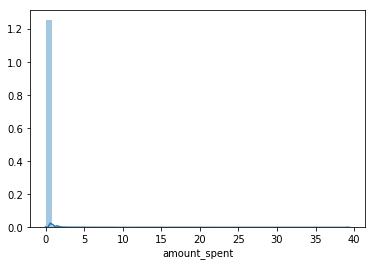

In [0]:
import seaborn as sns

# sns.distplot(oof_spent1)
sns.distplot(train_label['amount_spent'])

In [0]:
# import pandas
# from keras.models import Sequential
# from keras.layers import Dense,Dropout,LeakyReLU
# from keras.wrappers.scikit_learn import KerasClassifier
# from keras.utils import np_utils
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import minmax_scale
# from sklearn.pipeline import Pipeline
# # load dataset

# # encode class values as integers
# encoder = LabelEncoder()
# encoder.fit(train_label['survival_time'])
# encoded_time = encoder.transform(train_label['survival_time'])

# # convert integers to dummy variables (i.e. one hot encoded)
# train_dummy_time = np_utils.to_categorical(encoded_time)

# X_train = minmax_scale(train_time, feature_range=(0, 1), axis=0)
# X_test = minmax_scale(test1_time, feature_range=(0, 1), axis=0) 

# # define baseline model
# def baseline_model():
# 	# create model
#     model = Sequential()
#     model.add(Dense(64, input_dim=161))
#     model.add(LeakyReLU(0.1))
#     model.add(Dense(64))
#     model.add(LeakyReLU(alpha=0.01))
#     model.add(Dropout(0.01))
#     model.add(Dense(64, activation='softmax'))
#     # Compile model
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

# estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
# kf = KFold(n_splits=5, random_state = 42)
# results = cross_val_score(estimator, X_train, train_dummy_time, cv=kf)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))



# oof_time1 = np.zeros(len(train_time))
# oof_spent1 = np.zeros(len(train_spent))
# pred_time1 = np.zeros(len(test1_time))
# pred_spent1 = np.zeros(len(test1_spent))

# for trn_idx, val_idx in kf.split(train_spent):
#     params = {
#             'objective':'regression',
#             "boosting": "gbdt",
#             "num_iterations ":100,
#             'num_leaves': 10000,
#             'max_depth': 8,
#             'learning_rate': 0.1,
#             'min_data_in_leaf': 32, 
#             'min_child_samples': 30,
#             'min_child_weight': 0.5,
#             'min_split_gain': 0.005,
#             "feature_fraction": 0.9,
#             "bagging_fraction": 0.9 ,
#             "bagging_freq": 2,
#             "bagging_seed": 42,
#             "metric": 'rmse',
# #                 "device" : "gpu",
#             "lambda_l1": 0.1,
#             "lambda_l2": 0.1
#         }
#     train_df = lgb.Dataset(train_spent.drop(columns='acc_id').loc[trn_idx], label=train_label.loc[trn_idx, 'amount_spent'])
#     valid_df = lgb.Dataset(train_spent.drop(columns='acc_id').loc[val_idx], label=train_label.loc[val_idx, 'amount_spent'])

#     lgb_model = lgb.train(params, train_df, 5000, valid_sets = [train_df, valid_df], early_stopping_rounds = 500, verbose_eval=5000)
#     oof_spent1[val_idx] = lgb_model.predict(train_spent.loc[val_idx])/skf.n_splits
#     pred_spent1 += lgb_model.predict(test1_spent)/skf.n_splits


In [0]:
import seaborn as sns
sns.distplot(oof_time1)
sns.distplot(train_label['survival_time'])

NameError: ignored

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


,acc_id,survival_time,amount_spent
0,7,46.755751,0.127932
1,15,45.171316,0.290034
2,16,46.141189,0.079584
3,18,45.955809,0.043093
4,19,45.767334,0.026559
5,22,43.926631,0.087869
6,24,45.472084,0.077198
7,28,46.497815,0.071225
8,39,45.953976,0.169211
9,51,46.346413,0.109517


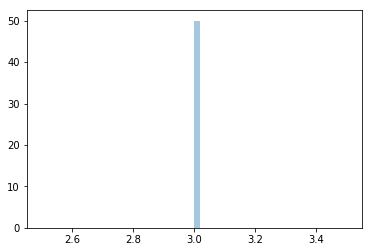

In [0]:
pt1 = scaler.fit_transform([pred_time1])
sns.distplot(pt1)
test1_predict = pd.DataFrame({'acc_id':test1_char['acc_id'],
                    'survival_time': pred_time1, #[j for i in pred_time1 for j in i], 
                    'amount_spent':pred_spent1})

test1_predict

In [0]:
kf = KFold(n_splits=5, random_state=42)
skf = StratifiedKFold(n_splits=5, random_state=42)

oof_time2 = np.zeros(len(train_time))
oof_spent2 = np.zeros(len(train_spent))
pred_time2 = np.zeros(len(test1_time))
pred_spent2 = np.zeros(len(test1_spent))

for trn_idx, val_idx in kf.split(train_spent):
    params = {
            'objective':'regression',
            "boosting": "gbdt",
            "num_iterations ":100,
            'num_leaves': 10000,
            'max_depth': 8,
            'learning_rate': 0.1,
            'min_data_in_leaf': 32, 
            'min_child_samples': 30,
            'min_child_weight': 0.5,
            'min_split_gain': 0.005,
            "feature_fraction": 0.9,
            "bagging_fraction": 0.9 ,
            "bagging_freq": 2,
            "bagging_seed": 42,
            "metric": 'rmse',
#                 "device" : "gpu",
            "lambda_l1": 0.1,
            "lambda_l2": 0.1
        }
    train_df = lgb.Dataset(train_spent.drop(columns='acc_id').loc[trn_idx], label=train_label.loc[trn_idx, 'amount_spent'])
    valid_df = lgb.Dataset(train_spent.drop(columns='acc_id').loc[val_idx], label=train_label.loc[val_idx, 'amount_spent'])

    lgb_model = lgb.train(params, train_df, 5000, valid_sets = [train_df, valid_df], early_stopping_rounds = 500, verbose_eval=5000)
    oof_spent2[val_idx] = lgb_model.predict(train_spent.loc[val_idx])/skf.n_splits
    pred_spen2t += lgb_model.predict(test1_spent)/skf.n_splits

for trn_idx, val_idx in skf.split(train_time, train_label['survival_time']):
    params = {
        'objective':'multiclass',
        'num_class':65,
        "boosting": "gbdt",
        "num_iterations ":100,
        'num_leaves': 10000,
        'max_depth': 8,
        'learning_rate': 0.1,
        'min_data_in_leaf': 32, 
        'min_child_samples': 30,
        'min_child_weight': 0.5,
        'min_split_gain': 0.005,
        "feature_fraction": 0.9,
        "bagging_fraction": 0.9 ,
        "bagging_freq": 2,
        "bagging_seed": 42,
        "metric": 'multi_logloss',
        "lambda_l1": 0.1,
        "lambda_l2": 0.1
    }
    
    train_df = lgb.Dataset(train.drop(columns='acc_id').loc[trn_idx], label=train_label.loc[trn_idx, 'survival_time'])
    valid_df = lgb.Dataset(train.drop(columns='acc_id').loc[val_idx], label=train_label.loc[val_idx, 'survival_time'])

    lgb_model = lgb.train(params, train_df, 5000, valid_sets = [train_df, valid_df], early_stopping_rounds = 500, verbose_eval=5000)
    oof_time2[val_idx] = lgb_model.predict(train_time.loc[val_idx])/skf.n_splits
    pred_time2 += lgb_model.predict(test1_time)/skf.n_splits

In [0]:
pred_time1 = scaler.fit_transform([pred_time1])
test2_predict = pd.DataFrame({'acc_id':test2_char['acc_id'],
                    'survival_time':[j for i in pred_time2 for j in i], 
                    'amount_spent':pred_spent2})

In [0]:
# oof_spent_1, pred_spent_1, oof_time_1,  pred_time_1 = lgb_model(train_char.loc[:,], test1_char, train_label, folds=FOLDS, seed=SEED)

Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.706428	valid_1's rmse: 0.778528
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.714998	valid_1's rmse: 0.745651
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.667298	valid_1's rmse: 0.904254
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.744864	valid_1's rmse: 0.620874
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[2]	training's rmse: 0.767065	valid_1's rmse: 0.496134
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 23.249	valid_1's rmse: 23.2628
Training until validation scores don't improve for 500 rounds.
Early stopping, best i

In [0]:
oof_time_1

array([9.14608778, 9.12227613, 9.14608778, ..., 9.19554655, 9.19026687,
       9.13112762])

In [0]:
X = (np.arange(64, dtype=np.float) + 1).reshape(-1, 1)
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

MinMaxScaler(copy=True, feature_range=(3, 64))

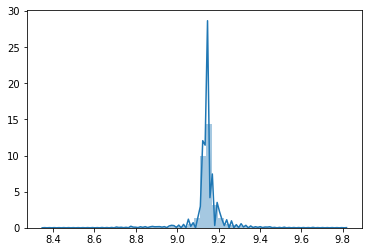

In [0]:
import seaborn as sns
sns.distplot(oof_time_1)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(3, 64))
s = scaler.fit([[1,3,4,5555,12]])
s
# oof_time = scaler.fit_transform(pd.DataFrame(oof_time_1))

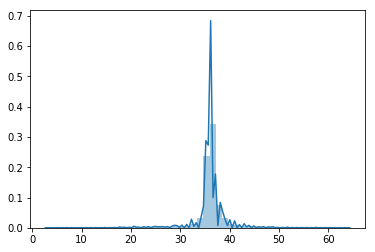

In [0]:
sns.distplot(oof_time)


In [0]:
oof_spent_2, pred_spent_2, oof_time_2,  pred_time_2 = lgb_model(train_char, test2_char.drop(columns='acc_id'), train_label, folds=FOLDS, seed=SEED)

Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.706428	valid_1's rmse: 0.778528
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.714998	valid_1's rmse: 0.745651
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.667298	valid_1's rmse: 0.904254
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.744864	valid_1's rmse: 0.620874
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[2]	training's rmse: 0.767065	valid_1's rmse: 0.496134
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 23.249	valid_1's rmse: 23.2628
Training until validation scores don't improve for 500 rounds.
Early stopping, best i

In [0]:
path = 'drive/My Drive/bigcontest2019/scripts'
os.chdir(path)
from model.metrics import score_function

In [0]:
oof_time

array([[36.14770262],
       [35.14892657],
       [36.14770262],
       ...,
       [38.22224279],
       [38.00078751],
       [35.52020105]])

In [0]:
oof = pd.DataFrame({'acc_id':train_label['acc_id'],'survival_time': [round(j) for i in oof_time for j in i] , 'amount_spent': list(oof_spent_1)})

In [0]:
score_function.score_function(train_label, train_label, path=False)

91693.76240883442


91693.76240883442

In [0]:
score_function.score_function(oof, train_label, path=False)

1786.3983875972945


1786.3983875972945

In [0]:
pred_time_1 = scaler.fit_transform(pd.DataFrame(pred_time_1))
pred_time_2 = scaler.fit_transform(pd.DataFrame(pred_time_2))

pred_time_1 = [round(j) for i in pred_time_1 for j in i]
pred_time_2 = [round(j) for i in pred_time_2 for j in i]

test1_predict = pd.DataFrame({'acc_id':test1_char['acc_id'],
                    'survival_time':pred_time_1, 
                    'amount_spent':pred_spent_1})

test2_predict = pd.DataFrame({'acc_id':test2_char['acc_id'],
                    'survival_time':pred_time_2, 
                    'amount_spent':pred_spent_2})


In [0]:
test1_predict.to_csv('test1_predict.csv',encoding='utf-8')
test2_predict.to_csv('test2_predict.csv',encoding='utf-8')

from google.colab import files

files.download('test1_predict.csv')
files.download('test2_predict.csv')